In [2]:
#!/usr/bin/env python

"""
This module contains code to plan coverage paths
"""

%matplotlib notebook
 
from shapely.geometry import Point, Polygon, LineString
from shapely.geometry import MultiLineString, MultiPoint
from shapely.geometry import GeometryCollection
from shapely.geos import TopologicalError
import math
import numpy as np
from copy import deepcopy
from matplotlib.collections import LineCollection
from pprint import pprint

from logging import error

import matplotlib.pyplot as plt


def generate_intersections(poly, width):
    "Subdivide a filed into coverage lines."
    starting_breakdown = poly.bounds[0:2]
    line = LineString([starting_breakdown, (starting_breakdown[0],
                                            starting_breakdown[1] +
                                            poly.bounds[3] - poly.bounds[1])])
    try:
        bounded_line = poly.intersection(line)
    except TopologicalError as e:
        error("Problem looking for intersection.", exc_info=1)
        return
    lines = [bounded_line]
    iterations = int(math.ceil((poly.bounds[2] - poly.bounds[0]) / width)) + 1
    for x in range(1, iterations):
        bounded_line = line.parallel_offset(x * width, 'right')
        if poly.intersects(bounded_line):
            try:
                bounded_line = poly.intersection(bounded_line)
            except TopologicalError as e:
                error("Problem looking for intersection.", exc_info=1)
                continue
            lines.append(bounded_line)
    return lines

def sort_to(point, list):
    "Sorts a set of points by distance to a point"
    l = deepcopy(list)
    l.sort(lambda x, y: cmp(x.distance(Point(*point)),
                            y.distance(Point(*point))))
    return l

def get_furthest(ps, origin):
    "Get a point along a line furthest away from a given point"
    orig_point = Point(*origin)
    return sorted(ps, lambda x, y: cmp(orig_point.distance(Point(*x)),
                                       orig_point.distance(Point(*y))))

def order_points(lines, initial_origin):
    "Return a list of points in a given coverage path order"
    origin = initial_origin
    results = []
    while True:
        if not len(lines):
            break
        lines = sort_to(origin, lines)
        f = lines.pop(0)
        if type(f) == GeometryCollection:
            continue
        if type(f) == MultiLineString:
            for ln in f:
                lines.append(ln)
            continue
        if type(f) == Point or type(f) == MultiPoint:
            continue
        xs, ys = f.xy
        ps = zip(xs, ys)
        (start, end) = get_furthest(ps, origin)
        results.append(origin)
        # results.append(start)
        results.append(start)
        # results.append(end)
        origin = end
    return np.vstack(results)

def bottom_left(points):
    """returns the bottom left point from the list of points given"""
    pass

def decompose(polygon, origin=None, width=1.0):
    """
    Decompose the field into a list of points to cover the field.
    """
    p = generate_intersections(polygon, width)
    if origin == None:
        return order_points(p, polygon.bounds[0:2])
    else:
        return order_points(p, origin)

Decomposition Time: 0.021290063858


<IPython.core.display.Javascript object>


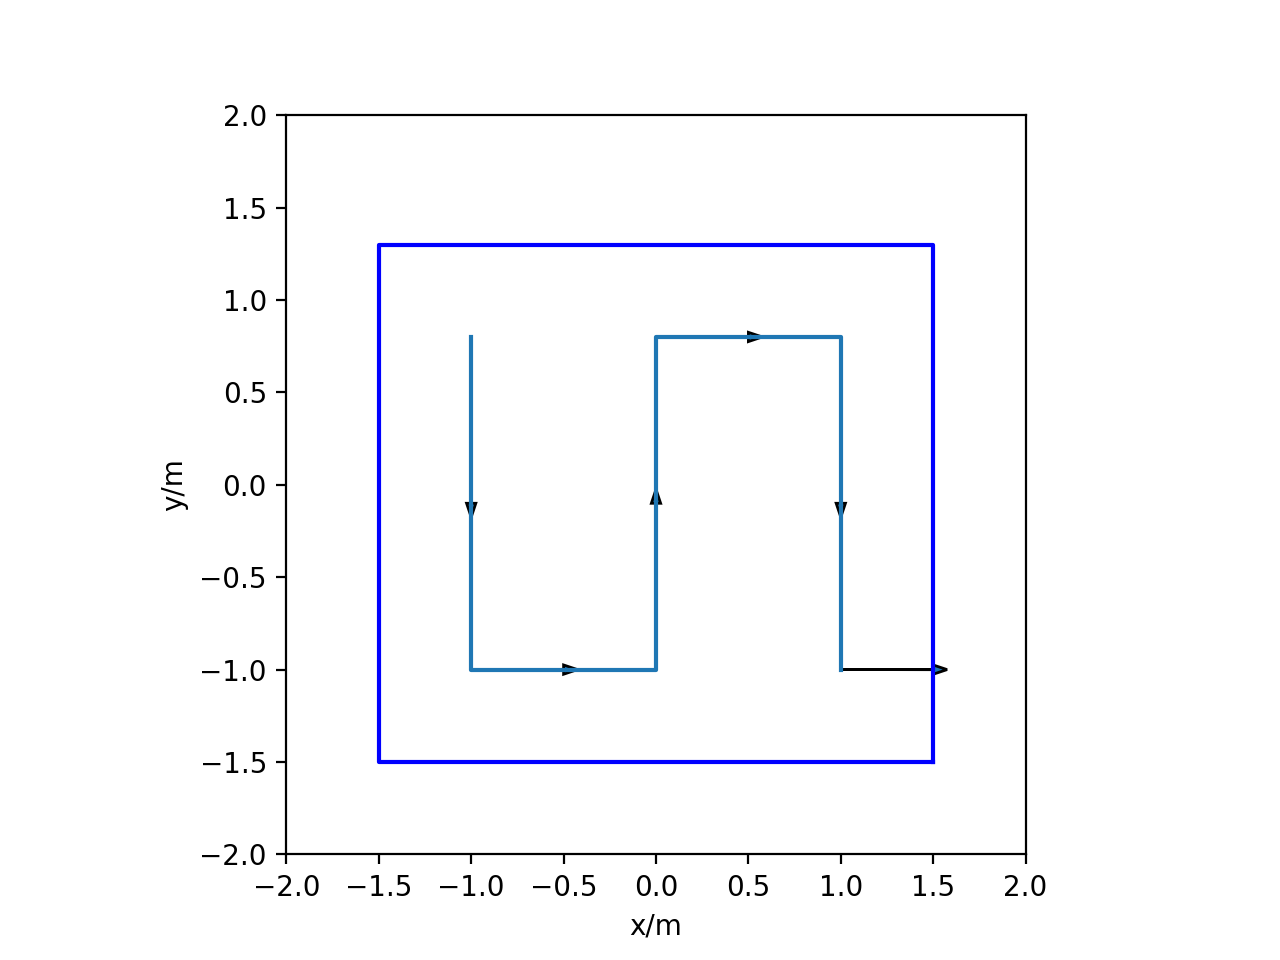

-1.0 0.8
-1.0 -1.0
0.0 -1.0
0.0 0.8
1.0 0.8
1.0 -1.0


In [10]:
from maptools import RotationTransform, rotation_tf_from_longest_edge
from maptools import rotate_polygon_to, make_axis, plot_polygon
from maptools import zoom_extents, rotate_from, plot_line, rotate_to
width=0.5
ww=1
ext_fu=np.array([(2, -1.5), (2, 1.3), (-1.5, 1.3), (-1.5, -1.5)])
ext_c = np.array([(1.5, -1.5), (1.5, 1.3), (-1.5, 1.3), (-1.5, -1.5)])
ext=np.array([[ 2.0, -1.5+width],
       [ 2.0,  1.3-width],
       [-1.5+width,  1.3-width],
       [-1.5+width, -1.5+width]])

polygon_c= Polygon(ext_c)
polygon = Polygon(ext)
polygon_points = np.array(polygon.exterior)

# rt = RotationTransform(66)

# tf_polygon = rotate_polygon_to(polygon, rt)

# origin = rotate_to(np.array([(0,0)]),rt).tolist()
origin=[-1.5+width,1.3-width]
from time import time; start = time()
result = decompose(polygon, origin, width=ww)
print "Decomposition Time:", time()-start

# tf_result = rotate_from(np.array(result), rt)

# ll = LineString(tf_result)

fig, ax = plt.subplots()
ax.plot(result[0:-1,0],result[0:-1,1])
for i in range(1,len(result)-1):
    print result[i][0],result[i][1]
    ax.arrow(result[i][0],result[i][1],(result[i+1][0]-result[i][0])*1.0/2,(result[i+1][1]-result[i][1])*1.0/2,head_width=0.05)

plot_polygon(polygon_c, ax, color='blue')
# plot_polygon(tf_polygon, ax, color='blue')
# plot_line(ll, ax)
# ax.axvline(x=0, color='black')
# ax.axhline(y=0, color='black')
# zoom_extents(ax, [polygon,tf_polygon])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
plt.show()
fig.savefig('./figs/bp_ac.eps', bbox_inches='tight')


